# Exploration Script

In [74]:
import sys
sys.path.append("../src")

# Loading in pre-built packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Self Built Functions that have been unit tested
from mmm.data.make_synthetic_panel import make_synthetic_panel
from mmm.data.transformations_datagen import adstock_datagen, hill_datagen

# Generating Synthetic Panel Data
panel_data = make_synthetic_panel(n_products=5, n_weeks=156)
panel_data.head()

,product_id,week,spend_tv,spend_search,spend_social,price,gdp_index,kpi_sales
0,0,0,3055.799898,3036.459214,1756.195344,104.701447,98.687890,27558.471409
1,0,1,6556.609921,4725.395939,1024.682082,104.329843,102.552586,33284.043328
2,0,2,7549.901027,4302.431623,651.390474,101.058049,103.358371,24795.121587
3,0,3,3045.632463,3042.501074,3128.586193,104.431970,101.289113,31549.183050
4,0,4,2886.613051,4240.475478,1029.051390,102.453834,102.347327,28823.294945


In [76]:
panel_data["product_id"].unique()

array([0, 1, 2, 3, 4], dtype=int64)

### Functions

In [70]:
# ----- Autocorrelation Function ----- 
def summarize_autocorr(data, prod_col="product_id", y_col="kpi_sales",
                       max_lag=52, ljung_lags=(6,12,24,52)):
    rows = []
    for pid, g in data.groupby(prod_col):
        y = g[y_col].astype(float).to_numpy()
        y = y[~np.isnan(y)]
        if len(y) < max_lag + 5:  # too short to be reliable
            continue
        pacf_vals = pacf(y, nlags=max_lag, method="ywm")
        acf_vals  = acf(y,  nlags=max_lag)
        lb = acorr_ljungbox(y, lags=list(ljung_lags), return_df=True)
        rows.append({
            "product": pid,
            "pacf_lag1": pacf_vals[1],
            "pacf_lag2": pacf_vals[2],
            "acf_lag52": acf_vals[52] if max_lag >= 52 else np.nan,
            "lb_p_6":  lb.loc[6, "lb_pvalue"]  if 6  in lb.index else np.nan,
            "lb_p_12": lb.loc[12,"lb_pvalue"] if 12 in lb.index else np.nan,
            "lb_p_24": lb.loc[24,"lb_pvalue"] if 24 in lb.index else np.nan,
            "lb_p_52": lb.loc[52,"lb_pvalue"] if 52 in lb.index else np.nan,
            "n_obs": len(y)
        })
    return pd.DataFrame(rows)

# ----- Lag term correlation -----
def compute_lagged_corr(data, y_col="kpi_sales", x_col="spend_tv", max_lag=4):
    """
    Compute correlation of y vs. lagged x (0...max_lag).
    Returns DataFrame with lag and correlation.
    """
    results = []
    y = data[y_col].reset_index(drop=True)

    for lag in range(max_lag + 1):
        x = data[x_col].shift(lag).reset_index(drop=True)
        corr = y.corr(x)  # Pearson correlation
        results.append({"lag": lag, "corr": corr})

    return pd.DataFrame(results)

# ----- Transformation Assessment -----
def check_transform_scatter(panel, product_id, spend_col, kpi_col,
                            lam=0.5, theta=5000, slope=1.0):
    """
    Apply adstock + Hill saturation to spend and compare vs KPI.

    Parameters
    ----------
    panel : DataFrame
        Your panel data
    product_id : int/str
        Product to filter
    spend_col : str
        Spend column name (e.g. "spend_tv")
    kpi_col : str
        KPI column name (e.g. "kpi_sales")
    lam, theta, slope : floats
        Transformation params
    """
    df = panel[panel["product_id"] == product_id].copy()
    x = df[spend_col].to_numpy(dtype=float)

    # transformations
    adstocked = adstock_datagen(x, lam)
    transformed = hill_datagen(adstocked, theta, slope)

    # pearson correlation
    r = np.corrcoef(transformed, df[kpi_col])[0, 1]

    # scatter plot
    sns.scatterplot(x=transformed, y=df[kpi_col], alpha=0.6)
    plt.title(f"{product_id} | {spend_col} vs {kpi_col}\n"
              f"lam={lam}, theta={theta}, slope={slope}, r={r:.2f}")
    plt.xlabel("Transformed spend")
    plt.ylabel(kpi_col)
    plt.show()

    return r

### Data Validation

In [58]:
# -------------------------------
# 1. Missing values
# -------------------------------
print("Missing values per column:")
print(panel_data.isnull().sum())
print("\n% missing values per column:")
print(panel_data.isnull().mean() * 100)

# -------------------------------
# 2. Data types & ranges
# -------------------------------
print("\nColumn dtypes:")
print(panel_data.dtypes)

numeric_cols = ["spend_tv", "spend_search", "spend_social", "price", "gdp_index", "kpi_sales"]

for col in numeric_cols:
    print(f"\n{col}: min={panel_data[col].min():.2f}, max={panel_data[col].max():.2f}, mean={panel_data[col].mean():.2f}")

negatives = (panel_data[numeric_cols] < 0)

if negatives.any().any():
    print("\nNegative values found in:")
    print(panel_data.loc[negatives.any(axis=1), numeric_cols])

# -------------------------------
# 3. Duplicate rows
# -------------------------------
duplicates = panel_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


# -------------------------------
# 4. Low variance columns
# -------------------------------
var = panel_data.var()
low_var_cols = var[var < 1e-6].index.tolist()
print("Near-constant columns:", low_var_cols)

constant_cols = [col for col in panel_data.columns if panel_data[col].nunique() == 1]
print("Constant no variance columns:", constant_cols)


# ------------------------------
# 5. Checking panel data structure
# ------------------------------
panel_data[panel_data['week'] == 0]


# ------------------------------
# 6. Product level spend variation
# ------------------------------
# Compute coefficient of variation (std/mean) per product × channel
spend_cols = [c for c in panel_data.columns if c.startswith("spend_")]

cv = (
    panel_data
    .groupby("product_id")[spend_cols]
    .agg(lambda x: x.std() / x.mean() if x.mean() != 0 else 0)
)

print(f"\n {cv}")

Missing values per column:
product_id      0
week            0
spend_tv        0
spend_search    0
spend_social    0
price           0
gdp_index       0
kpi_sales       0
dtype: int64

% missing values per column:
product_id      0.0
week            0.0
spend_tv        0.0
spend_search    0.0
spend_social    0.0
price           0.0
gdp_index       0.0
kpi_sales       0.0
dtype: float64

Column dtypes:
product_id        int64
week              int32
spend_tv        float64
spend_search    float64
spend_social    float64
price           float64
gdp_index       float64
kpi_sales       float64
dtype: object

spend_tv: min=901.23, max=27823.92, mean=7077.40

spend_search: min=333.88, max=11642.40, mean=3840.41

spend_social: min=116.09, max=6210.37, mean=1708.68

price: min=81.76, max=134.66, mean=109.90

gdp_index: min=96.88, max=118.37, mean=107.79

kpi_sales: min=0.00, max=89808.92, mean=42378.79

Number of duplicate rows: 0
Near-constant columns: []
Constant no variance columns: []

   

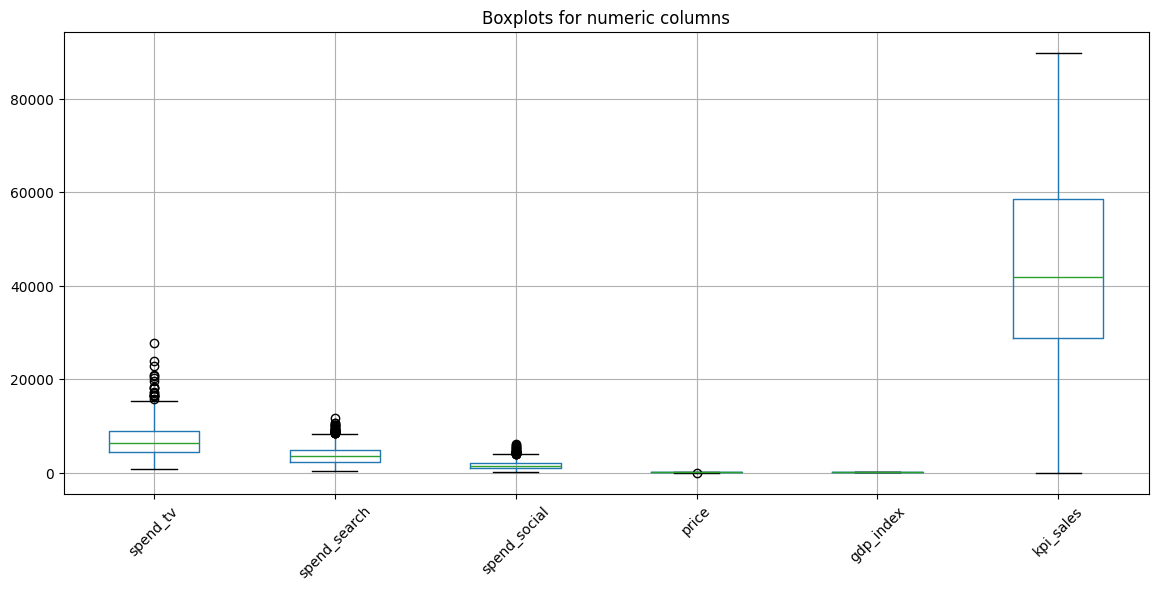

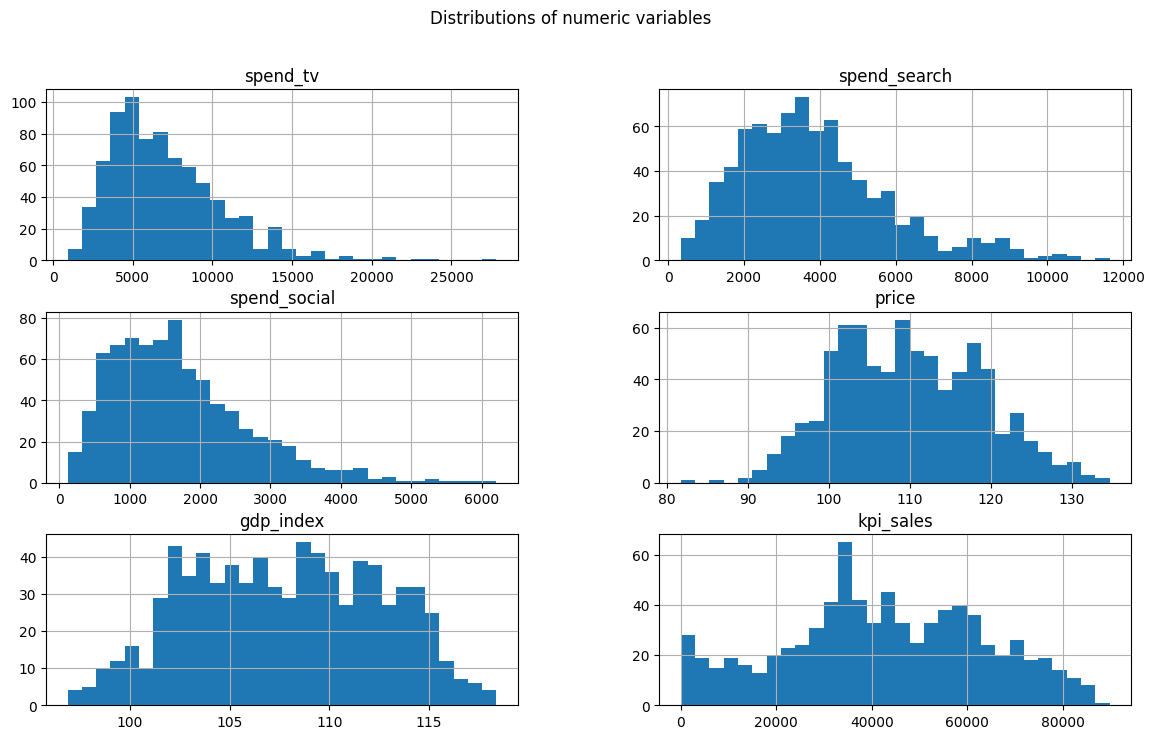


Number of potential outliers (>3 std deviations):
spend_tv        10
spend_search     8
spend_social     9
price            1
gdp_index        0
kpi_sales        0
dtype: int64


In [23]:
# -------------------------------
# Distributuions
# -------------------------------
# Quick boxplots
plt.figure(figsize=(14,6))
panel_data[numeric_cols].boxplot()
plt.title("Boxplots for numeric columns")
plt.xticks(rotation=45)
plt.show()

# Histograms
panel_data[numeric_cols].hist(bins=30, figsize=(14,8))
plt.suptitle("Distributions of numeric variables")
plt.show()

# Z-score method to flag extreme outliers
z_scores = panel_data[numeric_cols].apply(zscore)
outliers = (z_scores.abs() > 3).sum()
print("\nNumber of potential outliers (>3 std deviations):")
print(outliers)

### Identifying Seasonality and Trend in total KPI
Informs Feature Engineering

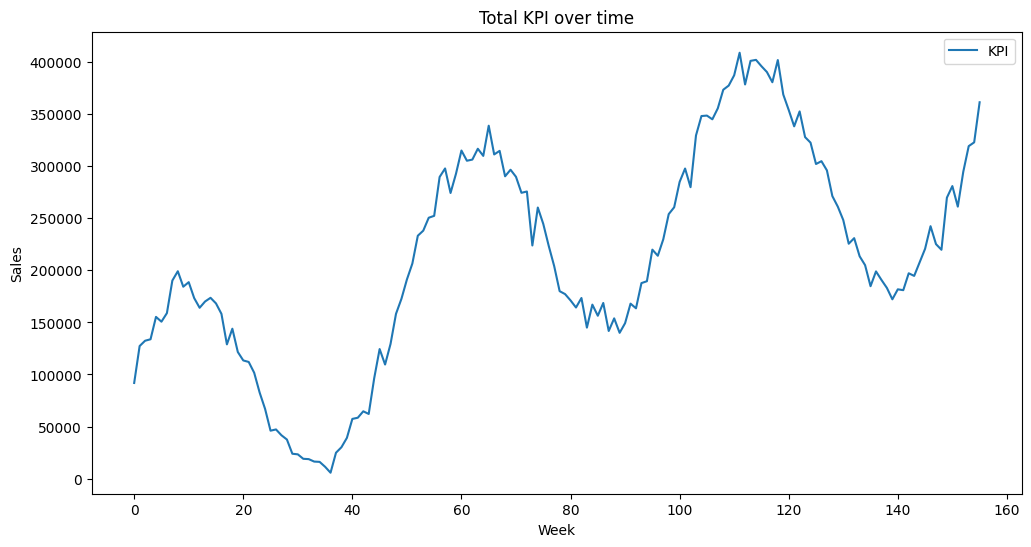

In [33]:
# Plotting KPI over time
kpi_total = panel_data.groupby("week")['kpi_sales'].sum()

# Plot KPI
plt.figure(figsize=(12,6))
plt.plot(kpi_total.index, kpi_total.values, label="KPI")
plt.title("Total KPI over time")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.legend()
plt.show() 

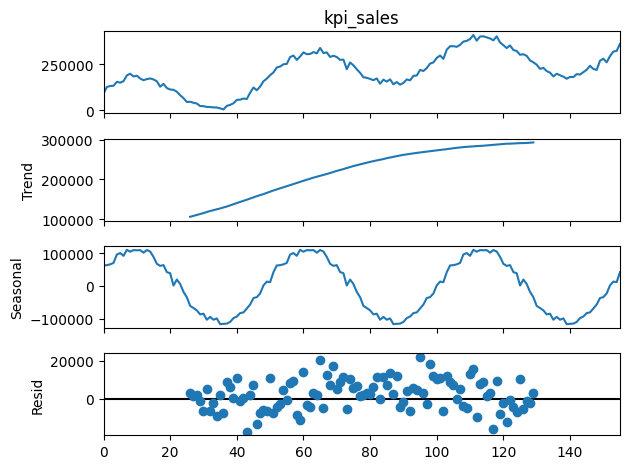

In [34]:
# Seasonally decomposing KPI 
decomp = seasonal_decompose(kpi_total, model = 'additive', period = 52)
decomp.plot()
plt.show()

        lb_stat  lb_pvalue
6   3377.563299        0.0
12  5052.748249        0.0
24  5432.614995        0.0
52  5752.295713        0.0


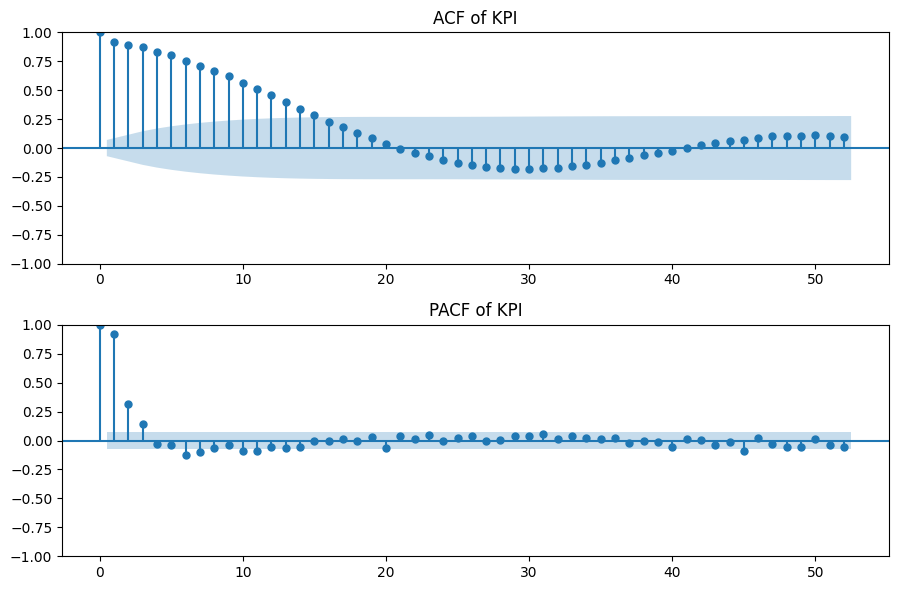

In [36]:
# Autocorrelation and partial plots - if positive inflates posteriors 
kpi = panel_data['kpi_sales'].copy()
kpi = kpi.dropna()

# ---- ACF & PACF plots ----
max_lag = 52  # weekly data: look up to a year
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
plot_acf(kpi, lags=max_lag, ax=ax[0])
ax[0].set_title("ACF of KPI")
plot_pacf(kpi, lags=max_lag, ax=ax[1], method="ywm")  # Yule–Walker–Mazumdar is robust
ax[1].set_title("PACF of KPI")
plt.tight_layout()

# ---- Ljung-Box Test ----
lb = acorr_ljungbox(kpi, lags=[6, 12, 24, 52], return_df=True)
print(lb)

### Trend and seasonality in product level KPI

In [50]:
# usage
panel_data = panel_data.sort_values(['product_id', 'week'])

summary = summarize_autocorr(panel_data, prod_col="product_id", y_col="kpi_sales", max_lag=52)
summary.sort_values("pacf_lag1", ascending=False).head()

,product,pacf_lag1,pacf_lag2,acf_lag52,lb_p_6,lb_p_12,lb_p_24,lb_p_52,n_obs
3,3,0.934865,0.267602,0.208515,9.316300e-156,9.670839e-236,2.683239e-246,5.449366e-247,156
1,1,0.928259,0.281437,0.232129,1.656154e-152,7.069780e-226,2.178119e-232,2.789506e-240,156
0,0,0.923994,0.384861,0.190828,3.131590e-153,7.175664e-229,9.737575e-237,1.164716e-239,156
2,2,0.922423,0.260937,0.205690,3.275642e-148,1.556339e-220,2.649995e-228,8.697365e-235,156
4,4,0.921641,0.456516,0.208238,4.536917e-152,7.434870e-222,8.025686e-228,1.185035e-233,156


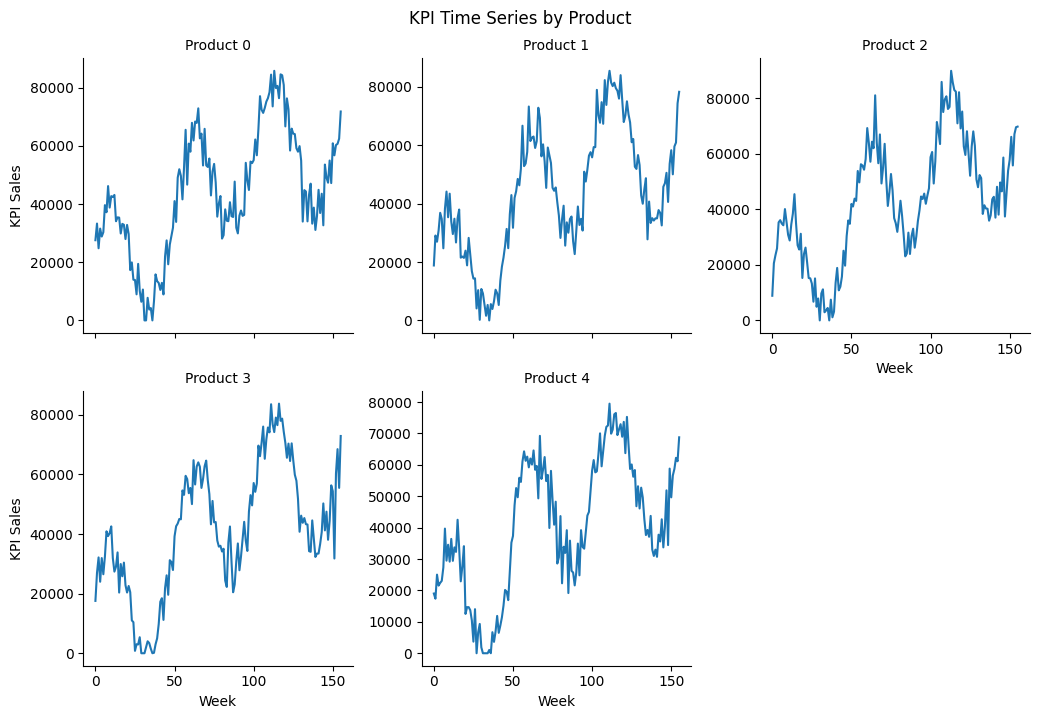

In [69]:
# Assessing KPI across products
g = sns.FacetGrid(panel_data, col="product_id", col_wrap=3, height=3.5, sharey=False)
g.map_dataframe(sns.lineplot, x="week", y="kpi_sales")
g.set_titles("Product {col_name}")
g.set_axis_labels("Week", "KPI Sales")
plt.suptitle("KPI Time Series by Product", y=1.02)
plt.show()

# Seasonal decomposition per product
# for prod, df in panel_data.groupby("product_id"):
#     result = seasonal_decompose(df.set_index("week")["kpi_sales"], period=52)  # weekly data
#     result.plot()
#     plt.suptitle(f"Product {prod} decomposition", y=1.02)
#     plt.show()

### Correlation Check 

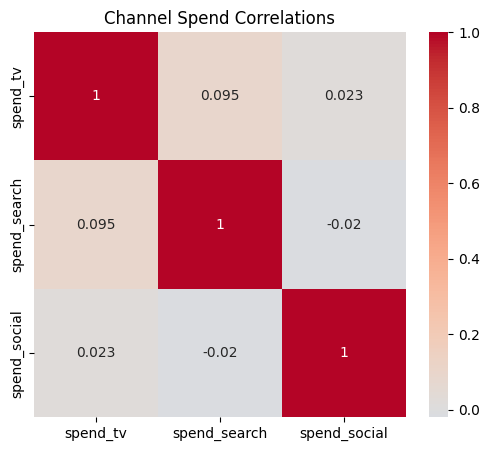

In [59]:
spend_cols = [c for c in panel_data.columns if c.startswith("spend_")]

# Correlation matrix across all products pooled
corr = panel_data[spend_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Channel Spend Correlations")
plt.show()

spend_tv vs KPI correlation: -0.02


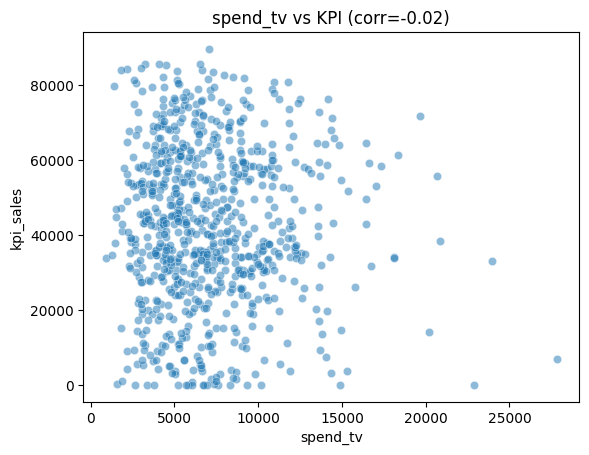

spend_search vs KPI correlation: -0.04


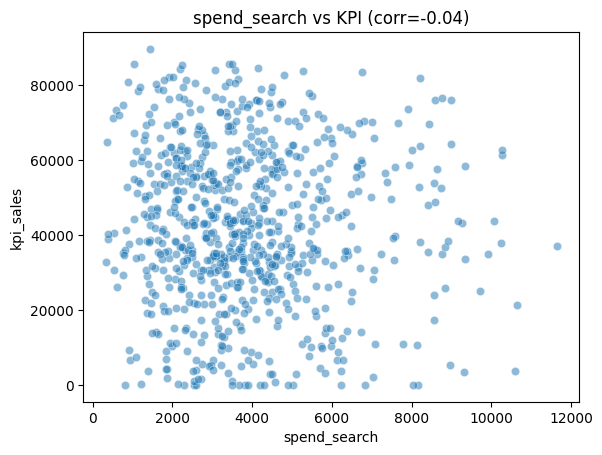

spend_social vs KPI correlation: -0.02


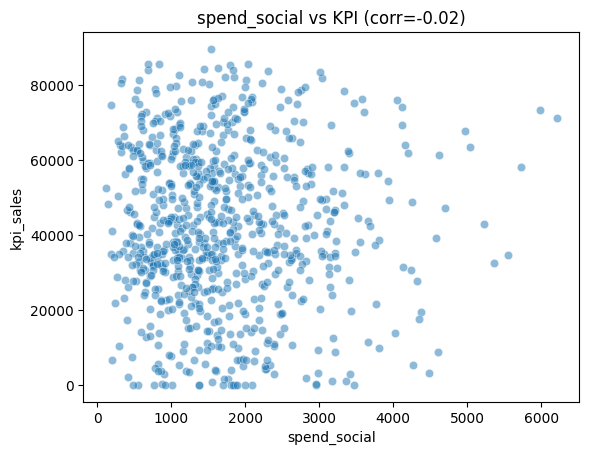

In [60]:
for ch in spend_cols:
    corr_val = panel_data[ch].corr(panel_data["kpi_sales"])
    print(f"{ch} vs KPI correlation: {corr_val:.2f}")

    sns.scatterplot(x=panel_data[ch], y=panel_data["kpi_sales"], alpha=0.5)
    plt.title(f"{ch} vs KPI (corr={corr_val:.2f})")
    plt.show()

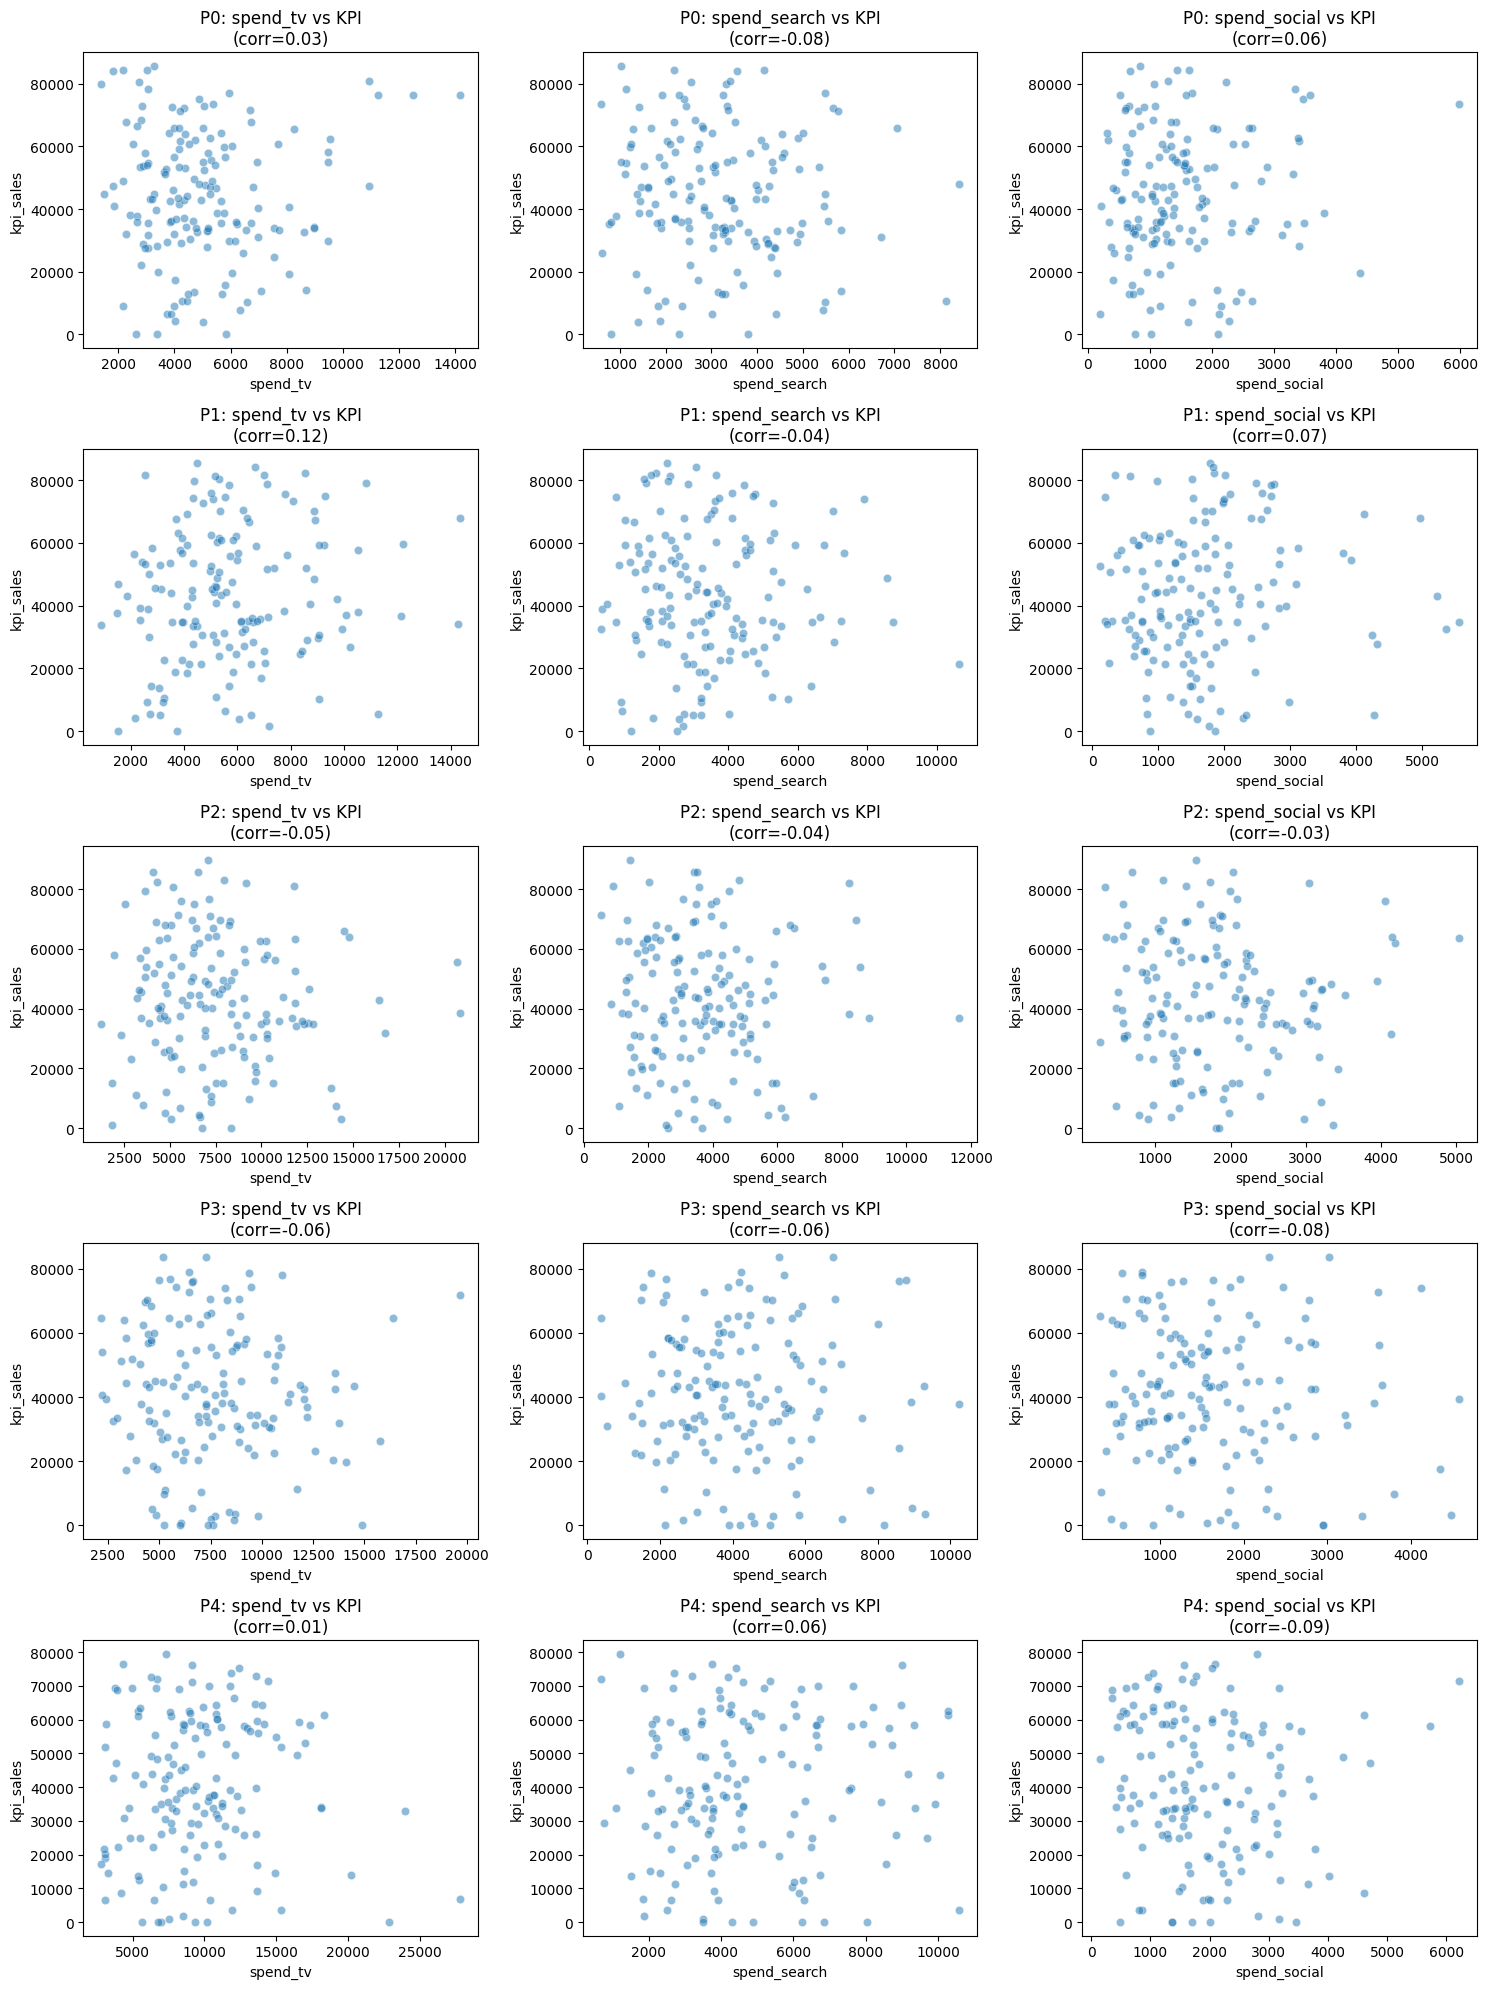

In [64]:
spend_cols = [c for c in panel_data.columns if c.startswith("spend_")]
products = panel_data["product_id"].unique()

# total subplots needed
n_plots = len(products) * len(spend_cols)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

i = 0
for prod in products:
    subset = panel_data[panel_data["product_id"] == prod]
    
    for ch in spend_cols:
        corr_val = subset[ch].corr(subset["kpi_sales"])
        sns.scatterplot(
            x=subset[ch], y=subset["kpi_sales"], alpha=0.5, ax=axes[i]
        )
        axes[i].set_title(f"P{prod}: {ch} vs KPI\n(corr={corr_val:.2f})")
        axes[i].set_xlabel(ch)
        axes[i].set_ylabel("kpi_sales")
        i += 1

# remove any unused axes
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

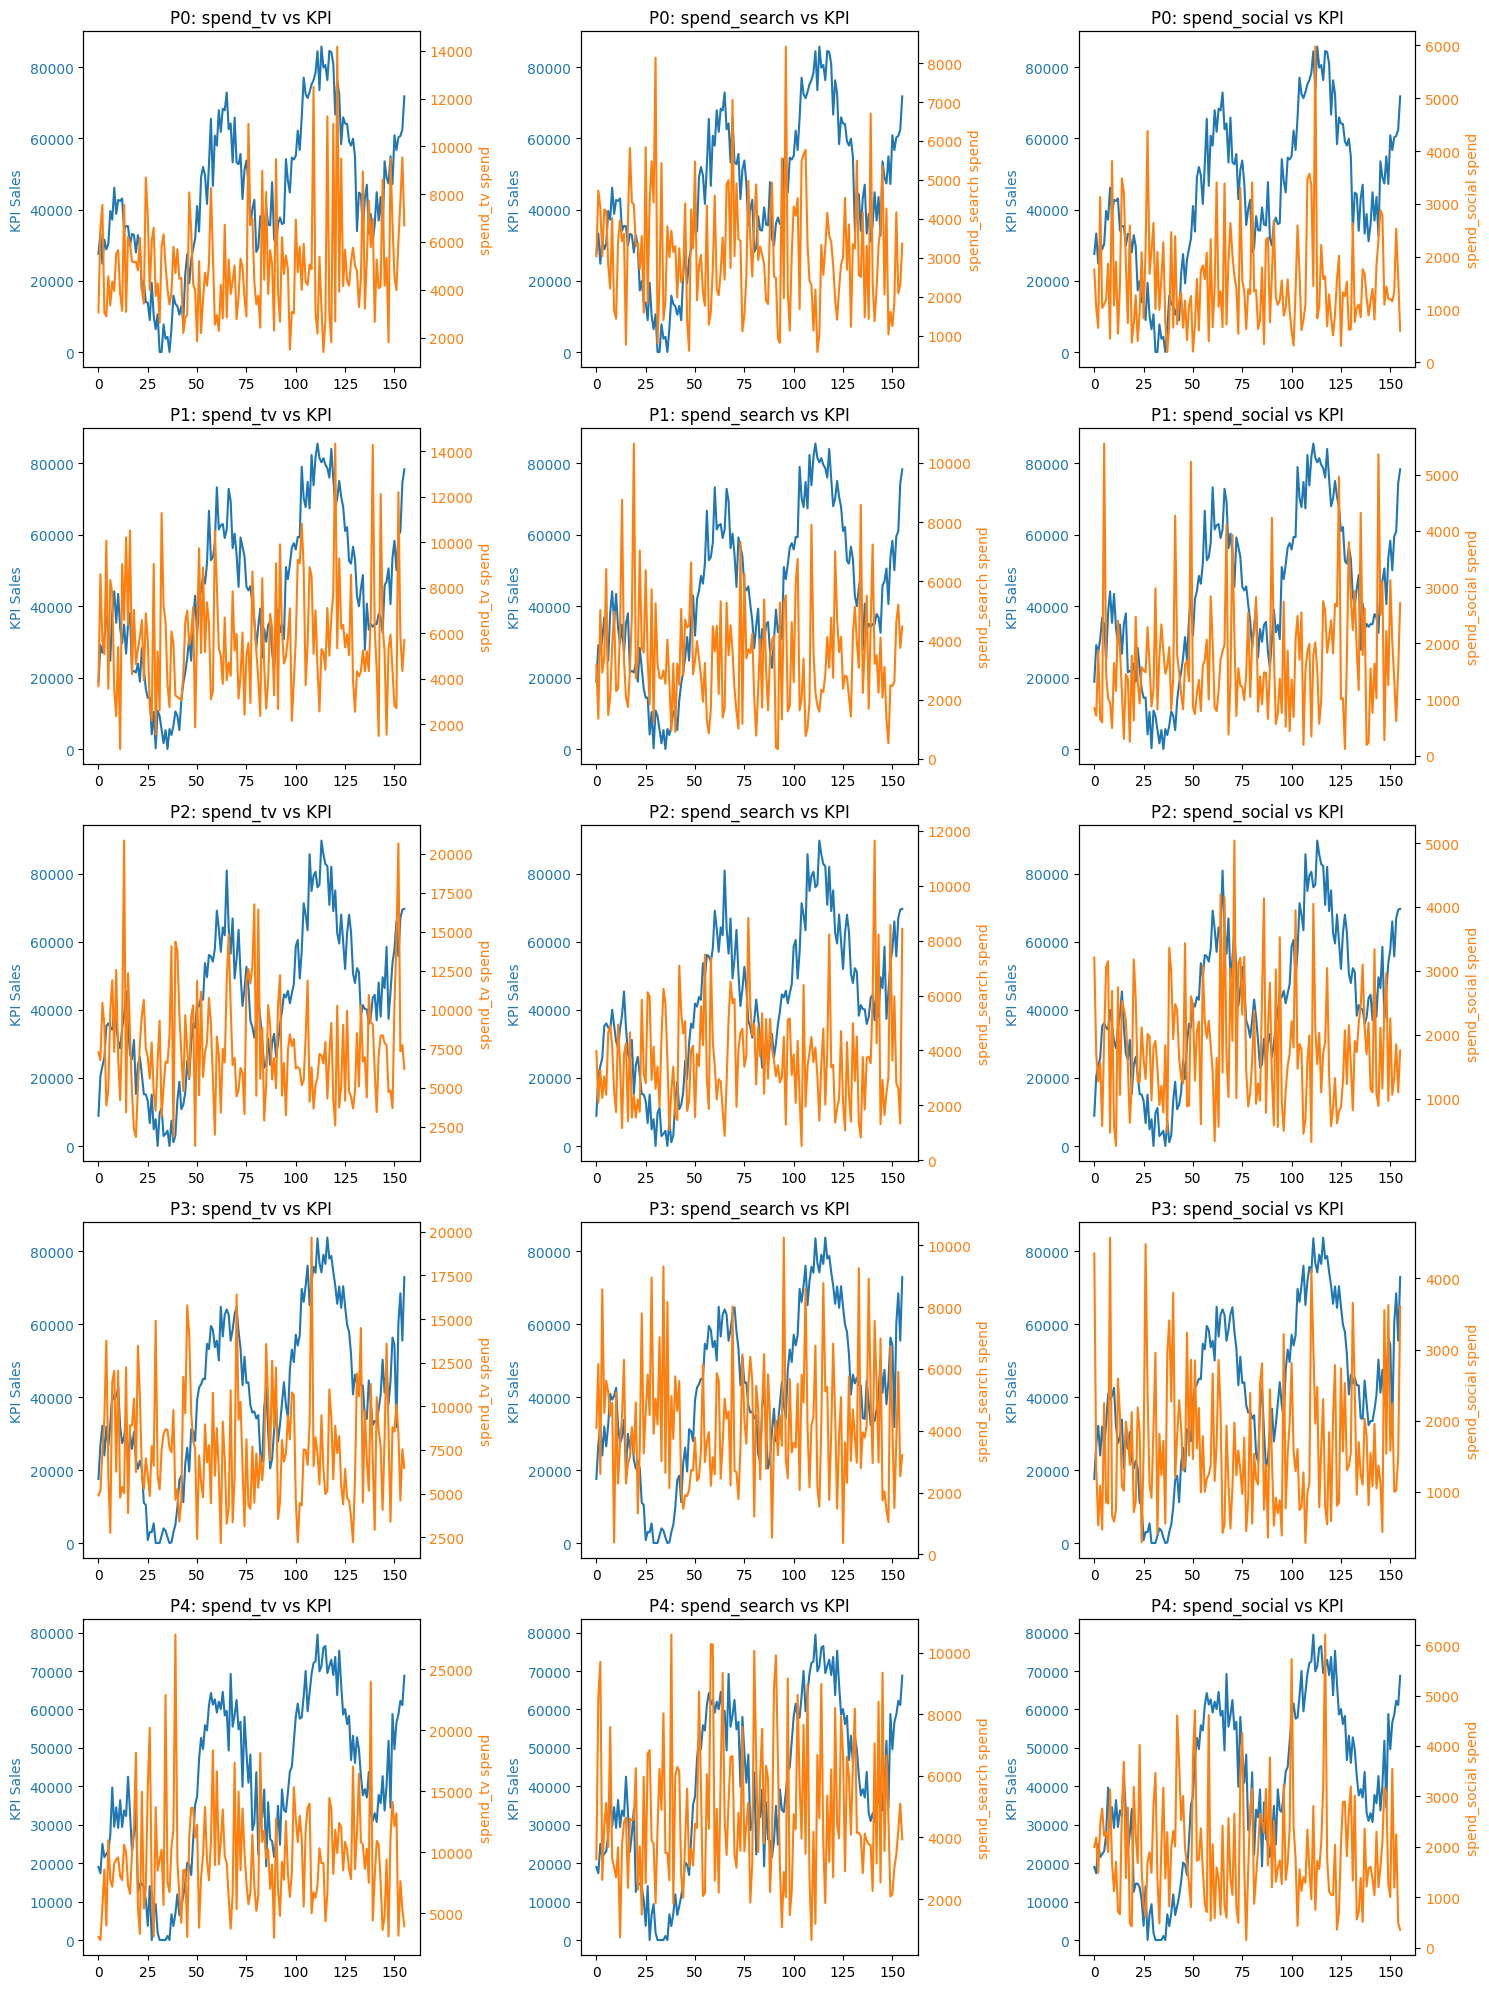

In [65]:
n_plots = len(products) * len(spend_cols)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

i = 0
for prod in products:
    subset = panel_data[panel_data["product_id"] == prod]
    
    for ch in spend_cols:
        ax1 = axes[i]
        
        # KPI on left axis
        ax1.plot(subset["week"], subset["kpi_sales"], color="tab:blue", label="KPI")
        ax1.set_ylabel("KPI Sales", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")
        
        # spend on right axis
        ax2 = ax1.twinx()
        ax2.plot(subset["week"], subset[ch], color="tab:orange", label=ch)
        ax2.set_ylabel(f"{ch} spend", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")
        
        ax1.set_title(f"P{prod}: {ch} vs KPI")
        i += 1

# delete unused axes
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Lag Analysis (Media Channel x KPI)

In [53]:
# Example usage per product and channel
prod_id = 0 
sub = panel_data[panel_data["product_id"] == prod_id]

for ch in ["spend_tv", "spend_search", "spend_social"]:
    ccf = compute_lagged_corr(sub, y_col="kpi_sales", x_col=ch, max_lag=4)
    print(f"\nProduct {prod_id}, Channel {ch}")
    print(ccf)


Product 0, Channel spend_tv
   lag      corr
0    0  0.034186
1    1  0.030120
2    2  0.027851
3    3 -0.012881
4    4 -0.055625

Product 0, Channel spend_search
   lag      corr
0    0 -0.082178
1    1 -0.112102
2    2 -0.106971
3    3 -0.109329
4    4 -0.122716

Product 0, Channel spend_social
   lag      corr
0    0  0.063817
1    1  0.094232
2    2  0.055783
3    3  0.062903
4    4  0.028842


### Post Transformation Analysis
- Determining appriopriate transformations to set adstock and saturation priors 

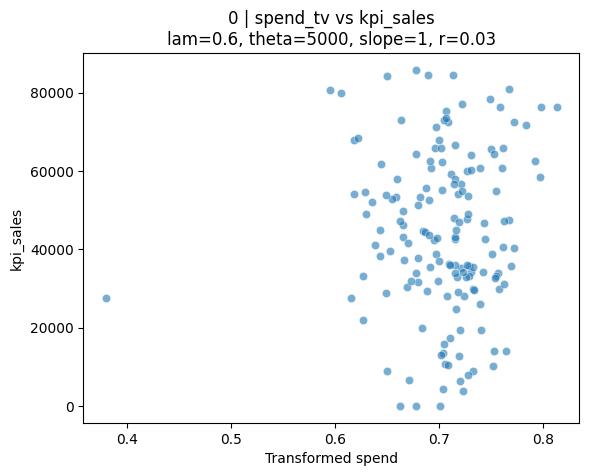

0.032252224763323484

In [73]:
check_transform_scatter(panel_data, product_id = 0, spend_col = "spend_tv", kpi_col = 'kpi_sales', lam = 0.6, theta = 5000, slope = 1)